<a href="https://colab.research.google.com/github/marcelogarret/projeto_mestrado/blob/main/PINN_garret_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
# Install the needed libraries
%pip install --upgrade pip
%pip install --upgrade "jax[cpu]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html optax flax

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html


In [66]:
from typing import Callable, Tuple, Optional, Union, List, Any
from dataclasses import dataclass, field
import jax
from jax import random, grad, vmap, jit, value_and_grad
from functools import partial
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import flax
from flax import linen as nn
from flax.training.train_state import TrainState
import optax


## The problem at hand

Imagine a system whose behavior is given by:

$$u(x) = \sin{(6x)}$$

The only information we have are $n_{meas}$ measurements of u, AND a differential equation that models its behavior, given by:

$$\frac{du}{dx} = 6 \cos{(6x)}$$

The example was taken from https://arxiv.org/abs/2101.08366

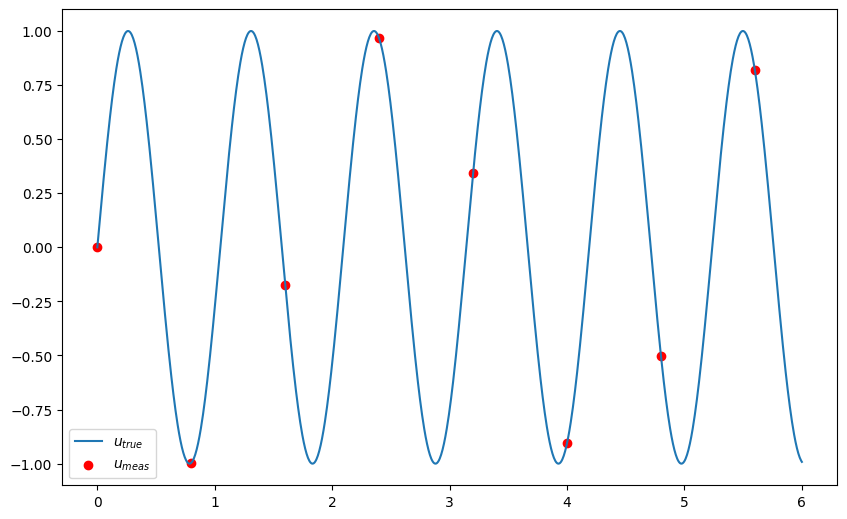

In [67]:
x = np.linspace(0,6,1001)

# The spacing between the measurements is 0.8
x_meas = np.arange(0,6,0.8)
n_meas = x_meas.shape[0]

u_true = np.sin(6 * x)

u_meas = np.sin(6 * x_meas)

fig, ax = plt.subplots(1,1, figsize=(10,10/1.618))

ax.plot(x, u_true, label=r'$u_{true}$')
ax.scatter(x_meas, u_meas, label=r'$u_{meas}$', color='red')

ax.legend()

## Approximating the system's behavior using a Neural Network

In [68]:
def _get_activation(activation_name):
    activations = {**jax.nn.__dict__, **jnp.__dict__}
    if activation_name in activations:
        return activations[activation_name]
    else:
        raise NotImplementedError("This activation function is not implemented yet!")


class DenseLayer(nn.Module):
    features: int
    kernel_init: Callable = nn.initializers.glorot_normal()
    bias_init: Callable = nn.initializers.zeros

    @nn.compact
    def __call__(self, x):
        kernel = self.param(
            "kernel",
            self.kernel_init,  # Initialization function
            (x.shape[-1], self.features),
        )

        bias = self.param("bias", self.bias_init, (self.features,))

        return jnp.dot(x, kernel) + bias

class Mlp(nn.Module):
    arch_name: Optional[str] = "Mlp"
    num_layers: int = 4
    layer_size: int = 64
    out_dim: int = 1
    activation: str = "tanh"
    lb: List = field(default_factory=List)
    ub: List = field(default_factory=List)
    extra_params: Any = None

    def setup(self):
        self.activation_fn = _get_activation(self.activation)
        self.lb_array = jnp.asarray(self.lb)
        self.ub_array = jnp.asarray(self.ub)

    @nn.compact
    def __call__(self, *inputs):
        # Normalize the inputs
        x = (
            2.0 * (jnp.stack(inputs) - self.lb_array) / (self.ub_array - self.lb_array)
            - 1.0
        )

        # Forward pass
        for _ in range(self.num_layers):
            x = DenseLayer(features=self.layer_size)(x)
            x = self.activation_fn(x)

        # Output layer
        x = DenseLayer(features=self.out_dim)(x)

        return x.flatten()

In [69]:
# Initialize the random key
rng_key = random.PRNGKey(42)

# Define the Neural Network
model = Mlp(num_layers = 2,
            layer_size = 32,
            out_dim = 1,
            lb = [0.0],
            ub = [6.0])

# Initialize the model parameters
rng_key, init_key = random.split(rng_key, 2)
dummy_input = jnp.asarray([0.0])
params = model.init(init_key, dummy_input)

## Define the optimizer using Optax
# The learning rate scheduler
lr = optax.exponential_decay(init_value=1e-3,
                             transition_steps=1000,
                             decay_rate=0.98)
tx = optax.adam(learning_rate=lr)

# Create the training state
state = TrainState.create(apply_fn=lambda params_, x_: model.apply(params_, x_)[0],
                          params=params,
                          tx=tx)

In [70]:
# Print the model structure in a fancy way
print(model.tabulate(rng_key, dummy_input))


                                     Mlp Summary                                      
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path         ┃ module     ┃ inputs        ┃ outputs       ┃ params                 ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│              │ Mlp        │ float32[1]    │ float32[1]    │                        │
├──────────────┼────────────┼───────────────┼───────────────┼────────────────────────┤
│ DenseLayer_0 │ DenseLayer │ float32[1,1]  │ float32[1,32] │ bias: float32[32]      │
│              │            │               │               │ kernel: float32[1,32]  │
│              │            │               │               │                        │
│              │            │               │               │ 64 (256 B)             │
├──────────────┼────────────┼───────────────┼───────────────┼────────────────────────┤
│ DenseLayer_1 │ DenseLayer │ float32[1,32

## How do we evaluate the model?

The solution for u(x=0.1) = -0.03748723492026329


Text(0.5, 1.0, 'Prediction BEFORE training the model')

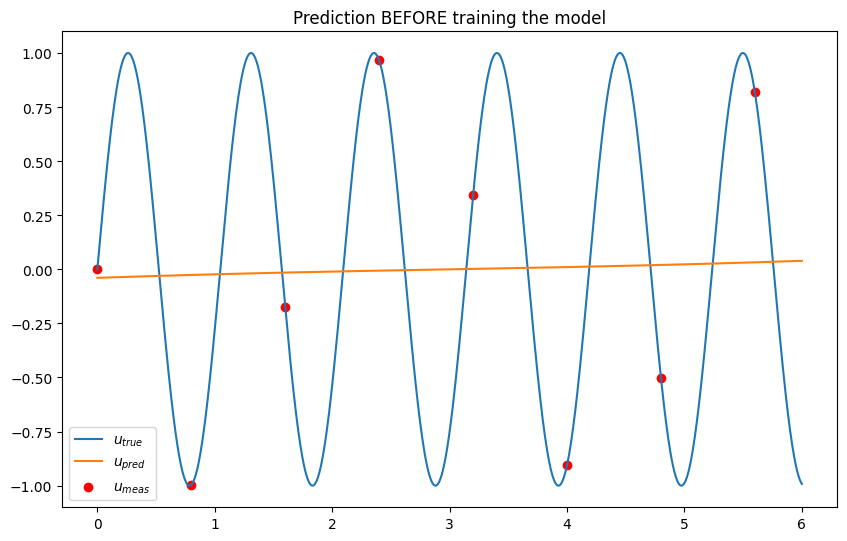

In [71]:
# To evaluate the model for a single example, i.e., for a single x input:
x_single = 0.1
u = state.apply_fn(state.params, x_single)
print(f"The solution for u(x={x_single}) = {u}")

# The solution evaluate at the entire domain:
u_pred = vmap(state.apply_fn, (None, 0))(state.params, x)

fig, ax = plt.subplots(1,1, figsize=(10,10/1.618))

ax.plot(x, u_true, label=r'$u_{true}$')
ax.plot(x, u_pred, label=r'$u_{pred}$')
ax.scatter(x_meas, u_meas, label=r'$u_{meas}$', color='red')

ax.legend()
ax.set_title('Prediction BEFORE training the model')

In [72]:
# Define the train step function
@jit
def train_step(state, batch):
    def pde_residual_fn(params, x):
        u_x = grad(state.apply_fn, argnums=1)(params, x)
        res = u_x - 6. * jnp.cos(6. * x)
        return res

    # Define the loss function
    def loss_fn(params, batch):
        u_pred = vmap(state.apply_fn, (None, 0))(params, batch['x'])
        res_pred = vmap(pde_residual_fn, (None, 0))(params, batch['x_pde'])

        data_loss = jnp.square(u_pred - batch['u']).mean()
        pde_loss = jnp.square(res_pred).mean()

        # total_loss = 20.0*data_loss + pde_loss
        total_loss = 1.0 * data_loss + 1.0 * pde_loss


        return total_loss, {'total_loss':total_loss, 'data_loss': data_loss, 'pde_loss': pde_loss}

    # Compute the loss and its grads w.r.t. the model parameters
    (_, loss_components), grads = value_and_grad(loss_fn, has_aux=True)(state.params, batch)
    state = state.apply_gradients(grads=grads)
    return loss_components, state

@jit
def eval_step(state, batch):
    def l2_error(params, batch):
        u_pred = vmap(state.apply_fn, (None, 0))(params, batch['x'])
        return jnp.linalg.norm(x=(u_pred - batch['u']), ord=2)/jnp.linalg.norm(x=batch['u'], ord=2)
    return l2_error(state.params, batch)

In [73]:
total_loss_log = []
data_loss_log = []
pde_loss_log = []
epoch_log = []
error_log = []

# Since this is a very small example, we don't even need to create a fancy sampler for batching our dataset.
train_batch = {'x': x_meas, 'u': u_meas, 'x_pde': jnp.linspace(0,6,101)}
eval_batch = {'x': x, 'u': u_true}

for epoch in range(20000):
    loss, state = train_step(state, train_batch)
    if epoch%100 == 0:
        l2_error = eval_step(state, eval_batch)

        epoch_log.append(epoch)
        total_loss_log.append(loss['total_loss'])
        data_loss_log.append(loss['data_loss'])
        pde_loss_log.append(loss['pde_loss'])
        error_log.append(l2_error)

        print(f"Epoch: {epoch} -- Total Loss: {loss['total_loss']}  -- Data Loss: {loss['data_loss']} -- PDE Loss: {loss['pde_loss']} -- Error: {l2_error}")

Epoch: 0 -- Total Loss: 18.537582397460938  -- Data Loss: 0.4696440100669861 -- PDE Loss: 18.06793785095215 -- Error: 1.0069663524627686
Epoch: 100 -- Total Loss: 18.490766525268555  -- Data Loss: 0.4698328673839569 -- PDE Loss: 18.020933151245117 -- Error: 1.026707410812378
Epoch: 200 -- Total Loss: 18.468917846679688  -- Data Loss: 0.4869290590286255 -- PDE Loss: 17.98198890686035 -- Error: 1.0369595289230347
Epoch: 300 -- Total Loss: 18.295841217041016  -- Data Loss: 0.5066185593605042 -- PDE Loss: 17.789222717285156 -- Error: 1.0307735204696655
Epoch: 400 -- Total Loss: 16.144563674926758  -- Data Loss: 0.28549617528915405 -- PDE Loss: 15.859067916870117 -- Error: 0.9948651194572449
Epoch: 500 -- Total Loss: 14.429535865783691  -- Data Loss: 0.34873253107070923 -- PDE Loss: 14.080802917480469 -- Error: 0.9430610537528992
Epoch: 600 -- Total Loss: 11.25574779510498  -- Data Loss: 0.15622492134571075 -- PDE Loss: 11.099522590637207 -- Error: 0.8565771579742432
Epoch: 700 -- Total Los

Text(0.5, 1.0, 'Prediction AFTER training the model')

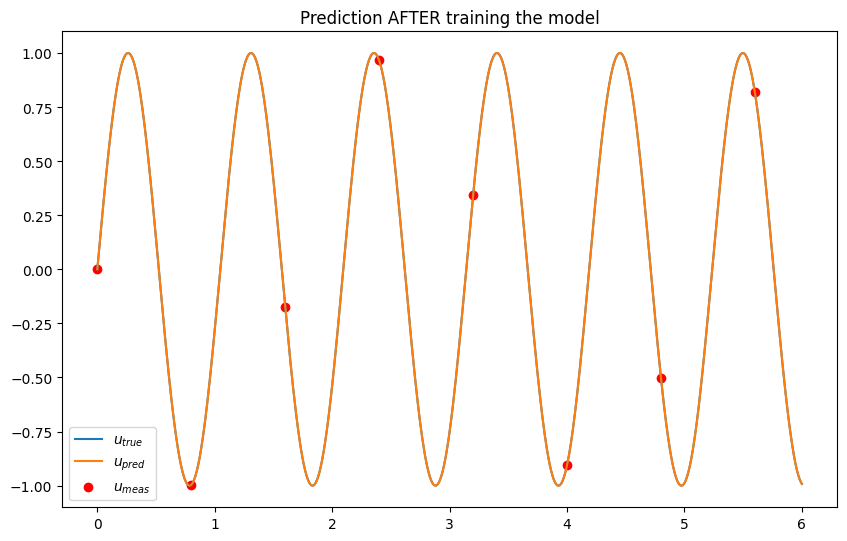

In [74]:
# The solution evaluate at the entire domain:
u_pred = vmap(state.apply_fn, (None, 0))(state.params, x)

fig, ax = plt.subplots(1,1, figsize=(10,10/1.618))

ax.plot(x, u_true, label=r'$u_{true}$')
ax.plot(x, u_pred, label=r'$u_{pred}$')
ax.scatter(x_meas, u_meas, label=r'$u_{meas}$', color='red')

ax.legend()
ax.set_title('Prediction AFTER training the model')

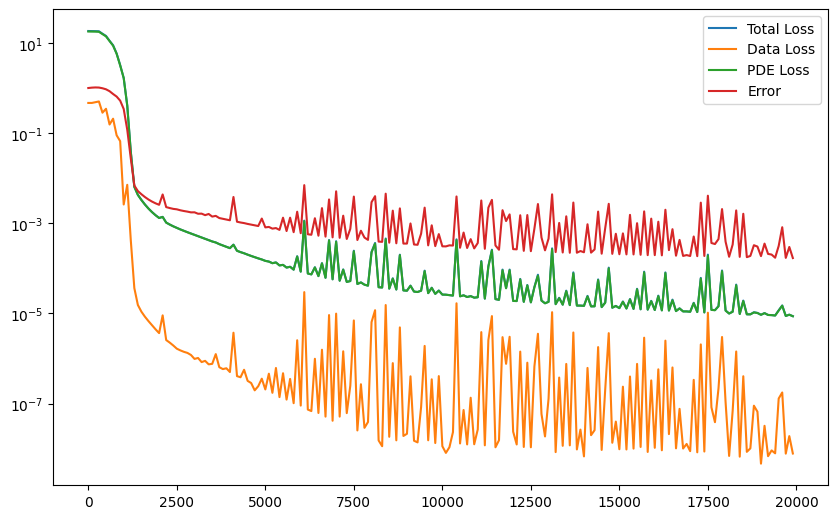

In [75]:
fig, ax = plt.subplots(1,1, figsize=(10,10/1.618))

ax.plot(epoch_log, total_loss_log, label='Total Loss')
ax.plot(epoch_log, data_loss_log, label='Data Loss')
ax.plot(epoch_log, pde_loss_log, label='PDE Loss')
ax.plot(epoch_log, error_log, label='Error')

ax.set_yscale('log')
ax.legend()